In [2]:
import astropy.io.fits as fits
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo


from galaxy_cluster_matching import match_galaxies_and_clusters
from completeness import create_completeness_dataframe
from mass_function import get_weighted_mass_histogram, get_region_volume 
from constants import MASS_BINS, Z_MAX, LOG_MASS_LUMINOSITY_RATIO_BINS
from richard_curve import get_mass_luminosity_cutoff, get_distance_from_mass, filter_for_richards_curve, get_mass_luminosity_histogram

In [3]:
# Loading the data

# big survey
sciencegkv_galaxies_raw = fits.open('../Data/GAMA/gkvScienceCatv02/gkvScienceCatv02.fits')[1].data

# small survey
galaxies_raw = fits.open('../Data/GAMA/merged/StellarMass-gkvScience/mergedStellarMass-gkvScience')[1].data

# cluster survey
# clusters_raw = fits.open('/home/farnoosh/farnoosh/Master_Thesis_all/Data/eFEDS/Mathias_Klug/efeds_members.fit')[1].data  # clusters EFEDS
clusters_raw = fits.open('../Data/eRASS/merged_primary&optical_clusters/merged_optical_primary_clusters.fits')[1].data  # eRASS western hemesphere

In [4]:
# some parameters for plotting
plt.rcParams.update({
    'font.size': 18,           # Font size for text
    'axes.titlesize': 18,      # Font size for axes titles
    'axes.labelsize': 16,      # Font size for x and y labels
    'xtick.labelsize': 16,     # Font size for x tick labels
    'ytick.labelsize': 16,     # Font size for y tick labels
    'legend.fontsize': 16,     # Font size for legend text
    'figure.figsize': (15, 8), # Default figure size
})

In [5]:
# Masks

# big survey masks
sciencegkv_galaxy_mask = (
    (sciencegkv_galaxies_raw['uberclass'] == 1) &           # classified as galaxy
    (sciencegkv_galaxies_raw['duplicate'] == 0) &           # unique object
    (sciencegkv_galaxies_raw['mask'] == False) &
    (sciencegkv_galaxies_raw['starmask'] == False) &
    (sciencegkv_galaxies_raw['Z'] < Z_MAX) &
    # (sciencegkv_galaxies_raw['Z'] <= 0.4) &
    # (sciencegkv_galaxies_raw['Z'] != -9.999) &
    # (sciencegkv_galaxies_raw['Z'] != 0) &
    # (sciencegkv_galaxies_raw['SC'] > 7) &                 # 95% redshift completeness limit for SC 7, and 98% for SC 8
    # (sciencegkv_galaxies_raw['NQ'] > 2) &                 # reliable redshift
    # (sciencegkv_galaxies_raw['RAcen'] > 129.0) &
    # (sciencegkv_galaxies_raw['RAcen'] < 141.0) &
    # (sciencegkv_galaxies_raw['Deccen'] > -2.0) &
    # (sciencegkv_galaxies_raw['Deccen'] < 3.0)  &
    (sciencegkv_galaxies_raw['flux_rt'] >= 5.011928e-05)    # maximum magnitude of 19.65 in r-band
)

# small survey masks
galaxy_mask = (
        (galaxies_raw['uberclass'] == 1) &           # classified as galaxy
        (galaxies_raw['duplicate'] == 0) &
        (galaxies_raw['mask'] == False) &
        (galaxies_raw['starmask'] == False) &
        (galaxies_raw['mstar'] > 0) &
        (galaxies_raw['NQ'] > 2) &                 # reliable redshift
        # (galaxies_raw['SC'] > 7) &
        # (galaxies_raw['Z'] <= 0.4) &
        (galaxies_raw['Z'] != 0) &
        (galaxies_raw['Z'] != -9.999) &
        (galaxies_raw['Z'] < Z_MAX) &
        # (galaxies_raw['RAcen'] > 129.0) &
        # (galaxies_raw['RAcen'] < 141.0) &
        # (galaxies_raw['Deccen'] > -2.0) &
        # (galaxies_raw['Deccen'] < 3.0)  &
        (galaxies_raw['flux_rt'] >= 5.011928e-05)
)

# cluster masks
cluster_mask = (
        # ~np.isnan(clusters_raw['VDISP']) &        # mask clusters which don't have VDISP values eFEDS
        # (clusters_raw['ZBEST'] <= Z_MAX) &        # eFEDS
        ~np.isnan(clusters_raw['VDISP_BOOT']) &     # Merged
        (clusters_raw['BEST_Z'] <= Z_MAX) &         # Merged
    (
        ((clusters_raw['RA'] > 129.0) & (clusters_raw['RA'] < 141.0) & (clusters_raw['DEC'] > -2.0) & (clusters_raw['DEC'] < 3.0)) |
        ((clusters_raw['RA'] > 174.0) & (clusters_raw['RA'] < 186.0) & (clusters_raw['DEC'] > -3.0) & (clusters_raw['DEC'] < 2.0)) |
        ((clusters_raw['RA'] > 211.5) & (clusters_raw['RA'] < 223.5) & (clusters_raw['DEC'] > -2.0) & (clusters_raw['DEC'] < 3.0)) |
        ((clusters_raw['RA'] > 339.0) & (clusters_raw['RA'] < 351.0) & (clusters_raw['DEC'] > -35.0) & (clusters_raw['DEC'] < -30.0))
    ) &
        (clusters_raw['R500'] != -1)             # Merged??????????????????????????????????????????????????
    
)



big_galaxy_catalog = sciencegkv_galaxies_raw[sciencegkv_galaxy_mask]
galaxy_catalog = galaxies_raw[galaxy_mask]
cluster_catalog = clusters_raw[cluster_mask]

In [6]:
completeness_region_df = create_completeness_dataframe(big_survey=big_galaxy_catalog,
                                                           small_survey=galaxy_catalog,
                                                           flux_type='flux_rt',
                                                           region="G09")
completeness_region_df['region'] = "G09"

/Users/benediktillich/Farnoosh_thesis/Thesis_code/completeness.py:52: RuntimeWarning: invalid value encountered in divide
  return np.cumsum(number_of_obj_small_survey)/np.cumsum(number_of_obj_big_survey)


In [7]:
# Dataframes
cluster_df = pd.DataFrame({
    # 'c_ID': cluster_catalog['ID-SRC'].byteswap().newbyteorder(),        #eFEDS
    'c_ID': cluster_catalog['DETUID'].byteswap().newbyteorder(),
    'c_NAME': cluster_catalog['NAME'].byteswap().newbyteorder(),
    'RA': cluster_catalog['RA'].byteswap().newbyteorder(),
    'DEC': cluster_catalog['DEC'].byteswap().newbyteorder(),
    'z': cluster_catalog['BEST_Z'].byteswap().newbyteorder(),
    'cluster_radius_kpc': cluster_catalog['R500'].byteswap().newbyteorder(),
    # 'cluster_radius_Mpc': cluster_catalog['R_LAMBDA'].byteswap().newbyteorder(),              # eFEDS
    # 'cluster_Velocity_Dispersion': cluster_catalog['VDISP'].byteswap().newbyteorder(),        # eFEDS
    'cluster_Velocity_Dispersion': cluster_catalog['VDISP_BOOT'].byteswap().newbyteorder(),

})



# Creating the galaxy DataFrame and merging with mass data 
galaxy_df = pd.DataFrame({
        'uberID': galaxy_catalog['uberID'].byteswap().newbyteorder(),
        'RA': galaxy_catalog['RAcen'].byteswap().newbyteorder(),
        'DEC': galaxy_catalog['Deccen'].byteswap().newbyteorder(),
        'z': galaxy_catalog['Z'].byteswap().newbyteorder(),
        'mstar': galaxy_catalog['mstar'].byteswap().newbyteorder(),
        'flux_rt': galaxy_catalog['flux_rt'].byteswap().newbyteorder(),
})

In [8]:
# Convert kpc to Mpc
cluster_df['cluster_radius_Mpc'] = cluster_df['cluster_radius_kpc'] / 1000

In [9]:
# LOOOOOOOOOOOOONG
# match the galaxies with the clusters
matched_galaxy_dataframe = match_galaxies_and_clusters(galaxy_dataframe=galaxy_df, cluster_dataframe=cluster_df)

Progress: 0.5372857804539138%%%%

KeyboardInterrupt: 

In [70]:
matched_galaxy_dataframe.to_csv('matched_galaxy_df.csv')

In [10]:
matched_galaxy_dataframe = pd.read_csv('matched_galaxy_df.csv')

In [11]:
# merge the df with the completeness with the df with the galaxy environment
merged_galaxy_df = pd.merge(completeness_region_df, matched_galaxy_dataframe, how="inner", on="uberID")

In [12]:
merged_galaxy_df['comoving_distance'] = cosmo.comoving_distance(merged_galaxy_df['z']).value

In [13]:
mass_to_light_histogram_all_galaxies = get_mass_luminosity_histogram(galaxy_df=merged_galaxy_df)
mass_to_light_histogram_low_mass_galaxies = get_mass_luminosity_histogram(galaxy_df=merged_galaxy_df[merged_galaxy_df["mstar"] < 10**10])
mass_luminosity_cutoff = get_mass_luminosity_cutoff(merged_galaxy_df, cut_off_percentage=80)
mass_for_richards_curve = np.logspace(5,12.25, 1000)
richards_curve = get_distance_from_mass(mass_for_richards_curve, log_cutoff_mass_to_light_ratio=mass_luminosity_cutoff)
merged_galaxy_df['within_richards_curve'] = merged_galaxy_df.apply(lambda row: filter_for_richards_curve(richards_curve, mass_for_richards_curve, row['mstar'], row['comoving_distance']), axis=1)

In [14]:
# find the percentile of the cutoff for the small galaxy catalog
bin_index = np.digitize(mass_luminosity_cutoff, mass_to_light_histogram_low_mass_galaxies[1]) - 1

if bin_index >= 0:  # Ensure bin index is valid
    count_below = np.sum(mass_to_light_histogram_low_mass_galaxies[0][:bin_index])
    total_count = np.sum(mass_to_light_histogram_low_mass_galaxies[0])
    percentage_below = (count_below / total_count) * 100
else:
    percentage_below = 0
    
print(f"{percentage_below:.2f}% of the values are below {mass_luminosity_cutoff}.")
print(f"number of galaxies in survey: {len(merged_galaxy_df)}")
print(f"number of small galaxies: {len(merged_galaxy_df[merged_galaxy_df['mstar'] < 10**10])}")

99.90% of the values are below 0.6565656565656568.
number of galaxies in survey: 45520
number of small galaxies: 8882


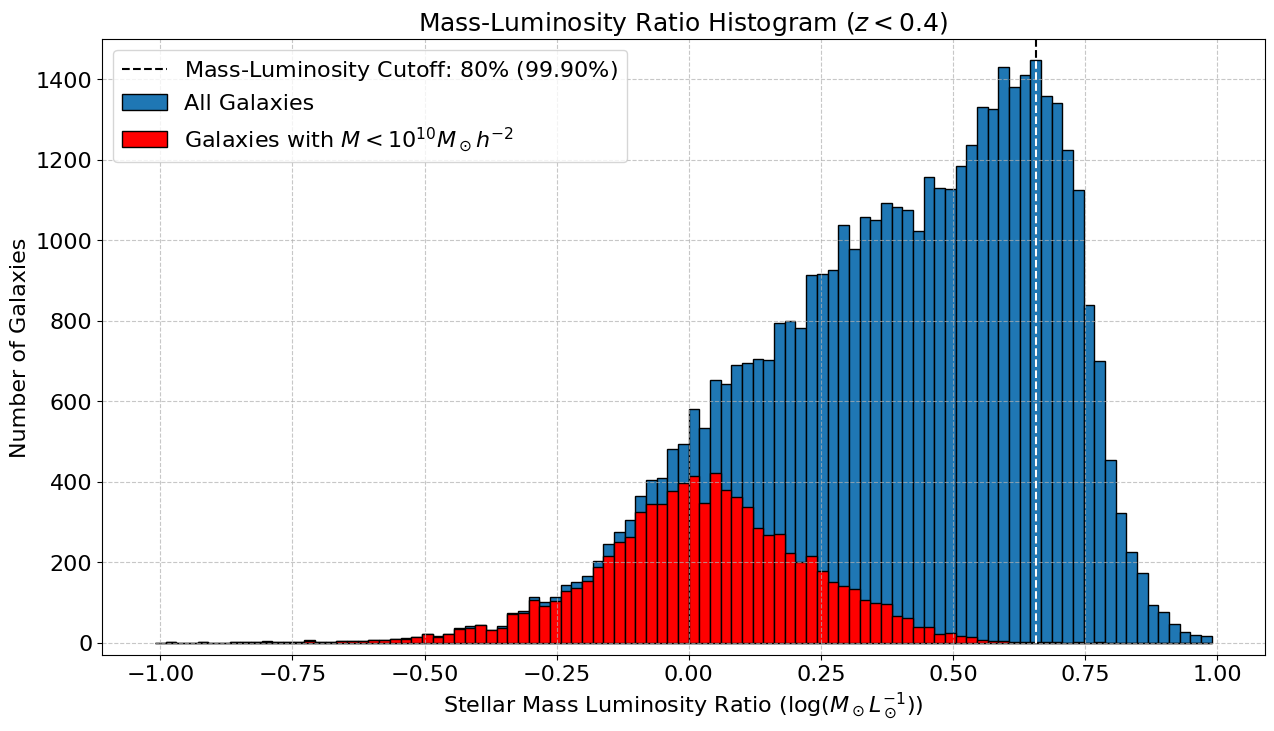

In [52]:
bin_width = LOG_MASS_LUMINOSITY_RATIO_BINS[1] - LOG_MASS_LUMINOSITY_RATIO_BINS[0]

plt.vlines(mass_luminosity_cutoff, ymin=0, ymax=1500, colors='k', linestyles='--', label=r"Mass-Luminosity Cutoff: $80\%$ ($99.90\%$)")
plt.bar(LOG_MASS_LUMINOSITY_RATIO_BINS[:-1], mass_to_light_histogram_all_galaxies[0], width=bin_width, edgecolor='black', label=r"All Galaxies")
plt.bar(LOG_MASS_LUMINOSITY_RATIO_BINS[:-1], mass_to_light_histogram_low_mass_galaxies[0], width=bin_width, edgecolor='black', label=r"Galaxies with $M < 10^{10} M_\odot h^{-2}$", color="red")
plt.vlines(mass_luminosity_cutoff, ymin=0, ymax=1450, colors='white', linestyles='--')

plt.xlabel(r"Stellar Mass Luminosity Ratio ($\log ( M_\odot L_\odot^{-1} ) $)")
plt.ylabel(r'Number of Galaxies')
plt.title(r'Mass-Luminosity Ratio Histogram ($z < 0.4$)')
plt.ylim((-30, 1500))
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.savefig('../plots/galaxy_mass_luminosity_histogram.pdf')
plt.show()

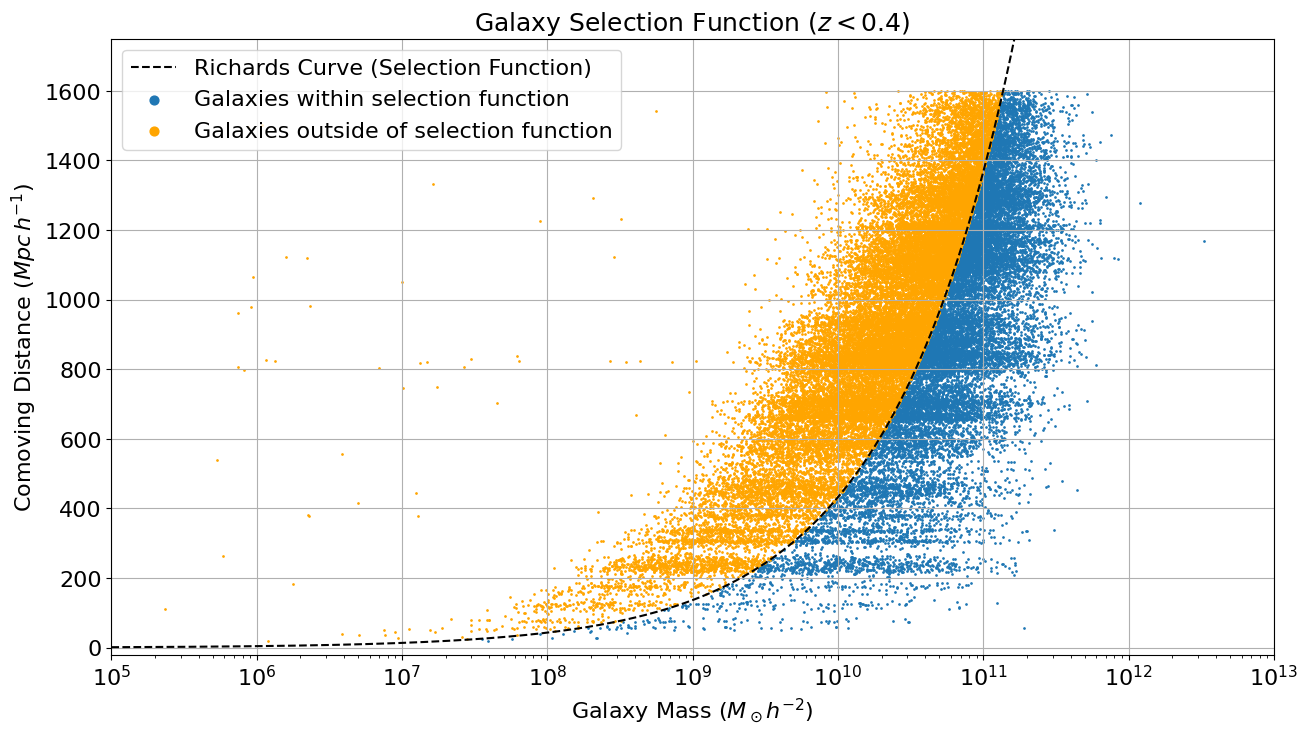

In [51]:
from matplotlib.legend_handler import HandlerPathCollection

plt.plot(mass_for_richards_curve, richards_curve, color='k', linestyle='--', label="Richards Curve (Selection Function)")
dots1 = plt.scatter(merged_galaxy_df[merged_galaxy_df['within_richards_curve']]['mstar'], merged_galaxy_df[merged_galaxy_df['within_richards_curve']]['comoving_distance'], s=0.9, label='Galaxies within selection function')
dots2 = plt.scatter(merged_galaxy_df[merged_galaxy_df['within_richards_curve']== False]['mstar'], merged_galaxy_df[merged_galaxy_df['within_richards_curve']== False]['comoving_distance'], color= 'orange',  s=0.9, label='Galaxies outside of selection function')

marker_size = 40
def update_prop(handle, orig):
    handle.update_from(orig)
    handle.set_sizes([marker_size])

plt.xscale('log')
plt.ylim(-20, 1750)
plt.xlim(10**5, 10**13)
plt.xlabel(r"Galaxy Mass ($M_\odot h^{-2}$)")
plt.ylabel(r"Comoving Distance ($Mpc\/ h^{-1}$)")
plt.title(r"Galaxy Selection Function ($z < 0.4$)")
plt.grid()
plt.legend(handler_map={type(dots1): HandlerPathCollection(update_func=update_prop), type(dots2): HandlerPathCollection(update_func=update_prop)})
plt.savefig("../plots/galaxy_selection_function.pdf")

In [13]:
mass_histogram, mass_histogram_error = get_weighted_mass_histogram(merged_galaxy_df[merged_galaxy_df['within_richards_curve']], region_name='G09')
stellar_mass_function = mass_histogram / get_region_volume('G09', MASS_BINS[:-1] , mass_luminosity_cutoff)

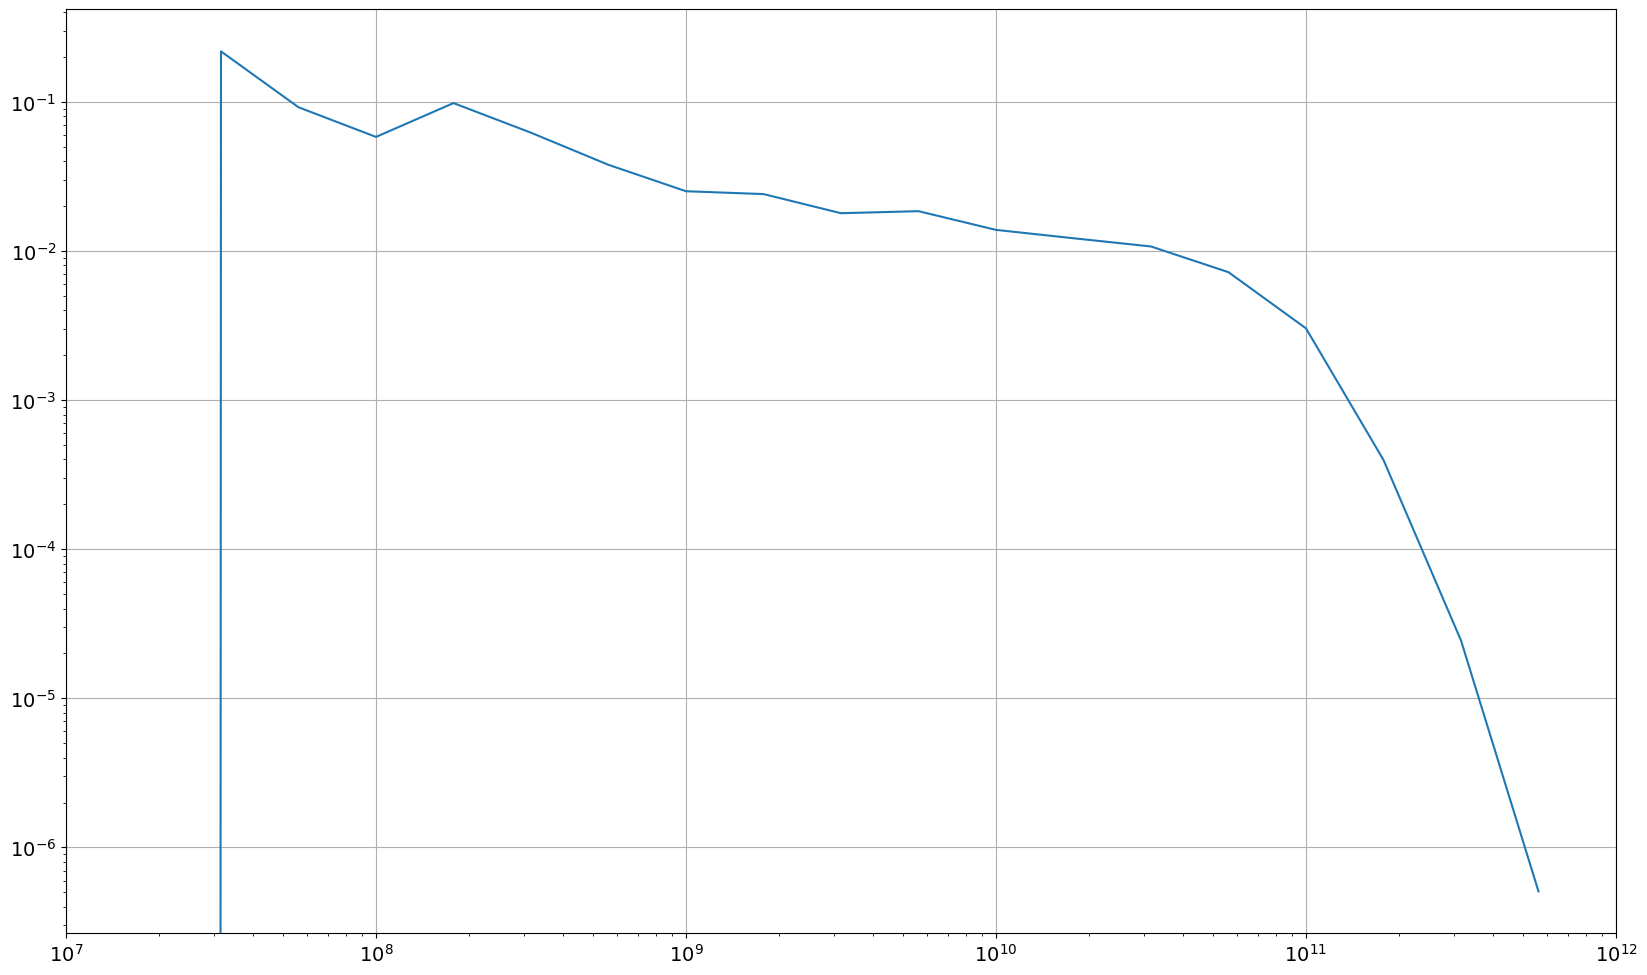

In [14]:
plt.plot(MASS_BINS[:-1], stellar_mass_function)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**7, 10**12)
plt.grid()